In [1]:
import pandas as pd
import numpy as np# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set plotting style
sns.set_theme(style='whitegrid')

import optuna
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\princ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\princ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\princ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('news.csv')

In [3]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
# Dropping Unnamed:0 and title column
df.drop(columns=['Unnamed: 0', 'title'], axis=1, inplace=True)

In [5]:
df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [6]:
df['text'][2]

'U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.\n\nKerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.\n\nThe visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.\n\nThe French press on Monday was filled with questions about why neither President Obama nor Kerry attended Sunday’s march, as about 40 leaders of other nations did. Obama was said to have stayed away because his own security needs can be taxing on a country, 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6335 non-null   object
 1   label   6335 non-null   object
dtypes: object(2)
memory usage: 99.1+ KB


In [8]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [9]:
df['label'].value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

All the labels are of almost same size, therefore, the dataset is balanced

# Preprocessing

In [10]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean text: remove stopwords, punctuation, and lemmatize as verbs
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Lowercasing
    words = [word.lower() for word in words]
    
    # Remove punctuation and handle contractions by replacing apostrophes
    words = [word.replace("’", "").replace("'", "") for word in words]
    words = [word for word in words if word not in string.punctuation and not word.isdigit()]
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize words as verbs
    words = [lemmatizer.lemmatize(word, pos='v') for word in words if word]  # Ensure no empty strings
    
    # Return the cleaned text
    return ' '.join(words)

# Apply the preprocessing to the 'text' column
df['text'] = df['text'].apply(preprocess_text)

# Display the first few rows of the cleaned dataset
df['text'].head()

0    daniel greenfield shillman journalism fellow f...
1    google pinterest digg linkedin reddit stumbleu...
2    u.s. secretary state john f. kerry say monday ...
3    — kaydee king kaydeeking november lesson tonig...
4    primary day new york front-runners hillary cli...
Name: text, dtype: object

In [11]:
df['text'][3]

'— kaydee king kaydeeking november lesson tonight dem losses time democrats start listen voters stop run establishment candidates — people bernie people4bernie november dems nt want tight race nt work bernie — walker bragman walkerbragman november new york time columnist paul krugman one hillary clinton outspoken surrogates contentious democratic primary blame clinton poor performance green party candidate jill stein far receive negligible number vote nationally say stein ralph nader prevent clinton victory account berniesteachers throw krugman analysis back face candidate issue take responsibility — teachers bernie berniesteachers november ana navarro republican recently endorse hillary clinton sum preposterous nature presidential election tweet gop nominate damn candidate could lose hillary clinton democrats nominate damn candidate could lose trump — ana navarro ananavarro november popular left-wing facebook page pro-sanders primary respond trump surge simply post meme sanders face t

#### Encoding the labels column

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

df.head()

,text,label
0,daniel greenfield shillman journalism fellow f...,0
1,google pinterest digg linkedin reddit stumbleu...,0
2,u.s. secretary state john f. kerry say monday ...,1
3,— kaydee king kaydeeking november lesson tonig...,0
4,primary day new york front-runners hillary cli...,1


In [13]:
print("Category to Label mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

Category to Label mapping: {'FAKE': 0, 'REAL': 1}


# EDA

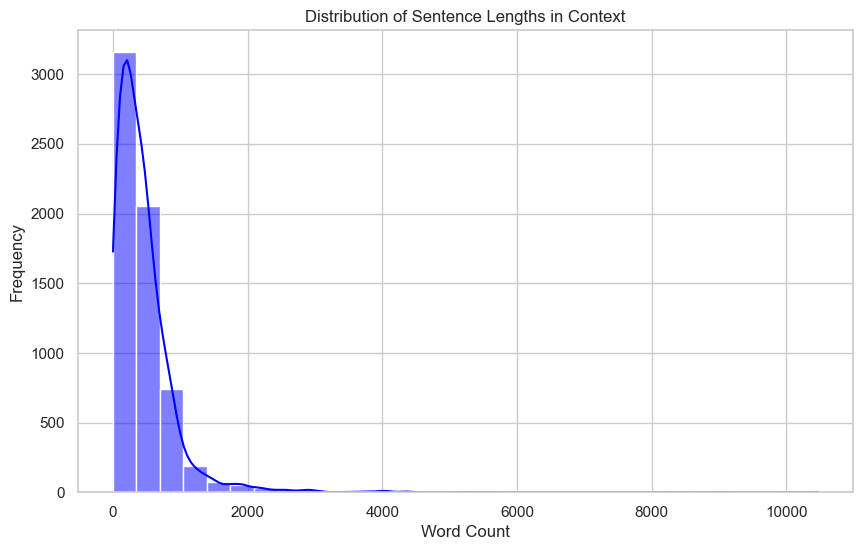

In [14]:
# Calculate sentence lengths (number of words) in the context column
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['text_word_count'], bins=30, kde=True, color='blue')
plt.title('Distribution of Sentence Lengths in Context')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Feature enginerring

In [15]:
#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['text'])
y = df['label']
X.shape, y.shape

((6335, 58564), (6335,))

In [16]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5068, 58564), (1267, 58564), (5068,), (1267,))

In [17]:
# Model building

rf = RandomForestClassifier()
lr = LogisticRegression()
mnb = MultinomialNB()

In [18]:
lr.fit(X_train, y_train)

LogisticRegression()

In [19]:
y_pred1 = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy:", accuracy)

Accuracy: 0.9179163378058406


In [20]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy)

Accuracy: 0.8397790055248618


In [21]:
rf.fit(X_train, y_train)
y_pred3 = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy)

Accuracy: 0.8397790055248618


In [22]:
def objective(trial):
    # Define classifier choice
    classifier_name = trial.suggest_categorical('classifier', [
        'RandomForest', 'GradientBoosting', 'SVM', 'LogisticRegression',
        'NaiveBayes', 'DecisionTree', 'KNN', 'XGBoost'
    ])
    
    # Define hyperparameters based on selected classifier
    if classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('rf_n_estimators', 10, 200)
        max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=True)
        min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 10)
        classifier = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        )
        
    elif classifier_name == 'GradientBoosting':
        n_estimators = trial.suggest_int('gb_n_estimators', 10, 200)
        learning_rate = trial.suggest_float('gb_learning_rate', 0.01, 0.3, log=True)
        max_depth = trial.suggest_int('gb_max_depth', 2, 10)
        classifier = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42
        )
        
    elif classifier_name == 'SVM':
        C = trial.suggest_float('svm_C', 0.1, 10.0, log=True)
        kernel = trial.suggest_categorical('svm_kernel', ['rbf', 'linear'])
        classifier = SVC(
            C=C,
            kernel=kernel,
            random_state=42
        )
        
    elif classifier_name == 'LogisticRegression':
        C = trial.suggest_float('lr_C', 0.1, 10.0, log=True)
        penalty = trial.suggest_categorical('lr_penalty', ['l1', 'l2'])
        classifier = LogisticRegression(
            C=C,
            penalty=penalty,
            solver='liblinear',
            random_state=42
        )
        
    elif classifier_name == 'NaiveBayes':
        alpha = trial.suggest_float('nb_alpha', 0.0, 1.0)
        classifier = MultinomialNB(alpha=alpha)
        
    elif classifier_name == 'DecisionTree':
        max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=True)
        min_samples_split = trial.suggest_int('dt_min_samples_split', 2, 10)
        classifier = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        )
        
    elif classifier_name == 'KNN':
        n_neighbors = trial.suggest_int('knn_n_neighbors', 1, 20)
        weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])
        classifier = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights
        )
        
    elif classifier_name == 'XGBoost':
        n_estimators = trial.suggest_int('xgb_n_estimators', 10, 200)
        max_depth = trial.suggest_int('xgb_max_depth', 2, 10)
        learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True)
        classifier = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )
    
    # Fit the model and return the score
    score = cross_val_score(classifier, X_train, y_train, cv=5).mean()
    return score

In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-03-26 16:44:14,520] A new study created in memory with name: no-name-a76d620a-b461-4096-afed-e6bbf5f3d103
[I 2025-03-26 16:44:15,424] Trial 0 finished with value: 0.918904342171105 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 3.7564243726454243, 'lr_penalty': 'l1'}. Best is trial 0 with value: 0.918904342171105.
[I 2025-03-26 16:44:16,167] Trial 1 finished with value: 0.8979892560422593 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.505104410511204, 'lr_penalty': 'l2'}. Best is trial 0 with value: 0.918904342171105.
[I 2025-03-26 16:44:16,253] Trial 2 finished with value: 0.8374110917052674 and parameters: {'classifier': 'NaiveBayes', 'nb_alpha': 0.7502578016308721}. Best is trial 0 with value: 0.918904342171105.
[I 2025-03-26 16:44:18,518] Trial 3 finished with value: 0.587608817132699 and parameters: {'classifier': 'KNN', 'knn_n_neighbors': 6, 'knn_weights': 'distance'}. Best is trial 0 with value: 0.918904342171105.
[I 2025-03-26 16:44:22,855]

In [24]:
# Print the best result
print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print(f"  Params: {trial.params}")

Best trial:
  Accuracy: 0.9277837812578491
  Params: {'classifier': 'SVM', 'svm_C': 9.709950709396484, 'svm_kernel': 'rbf'}


  Accuracy: 0.9277837812578491
  Params: {'classifier': 'SVM', 'svm_C': 9.709950709396484, 'svm_kernel': 'rbf'}

In [22]:
X = df[['text']]
y = df['label']

In [23]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [46]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [47]:
# Define the ColumnTransformer for the features (only 'text' in this case)
from sklearn.compose import ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), 'text')
    ],
    remainder='passthrough'  # Not needed here since there's only one column
)

In [48]:
from sklearn.pipeline import Pipeline
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('classifier', SVC(C=9.709950709396484, kernel='rbf'))
])

In [49]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf', TfidfVectorizer(),
                                                  'text')])),
                ('classifier', SVC(C=9.709950709396484))])

In [ ]:
y_pred = pipeline.predict(X_test)

In [53]:
# Calculate the accuracy score
score = accuracy_score(y_test, y_pred)
print(f"Accuracy: {score:.4f}")

Accuracy: 0.9361


In [57]:
from sklearn.metrics import classification_report, confusion_matrix
# Print classification report
print(classification_report(y_test, y_pred, target_names=[str(label) for label in le.classes_]))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       628
           1       0.95      0.92      0.94       639

    accuracy                           0.94      1267
   macro avg       0.94      0.94      0.94      1267
weighted avg       0.94      0.94      0.94      1267



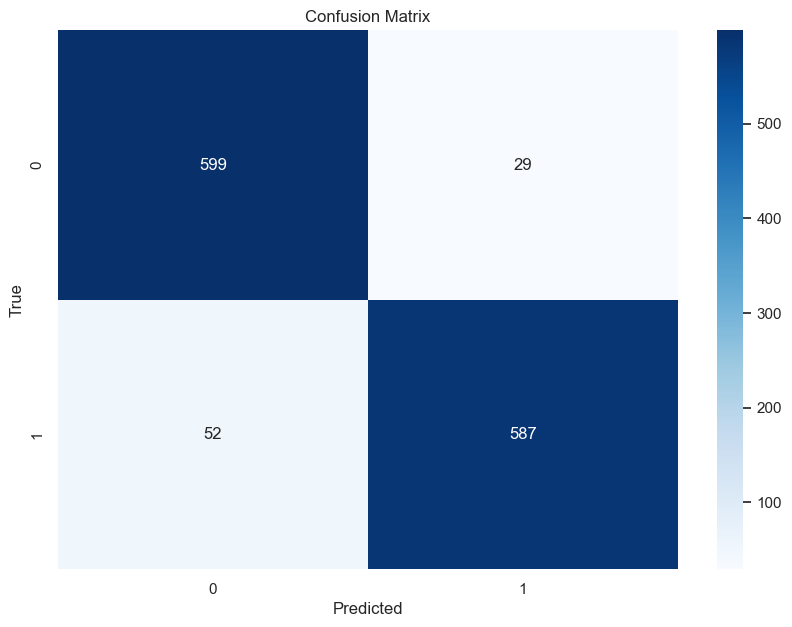

In [58]:
# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [61]:
# predicting on new data
new_data = [""""ADDIS ABABA, Ethiopia —President Obama convened a meeting with the leaders of several East African nations and the African Union on Monday in an effort to address the worsening situation in South Sudan, even as he met with Ethiopia’s prime minister to discuss how to strengthen human rights and democratic institutions here.

With no resolution in sight for the ongoing conflict in South Sudan, Obama brought together top officials from Ethiopia, Uganda, Kenya, Sudan and the A.U. to chart out a strategy in the event that the latest round of peace talks fail.

African nations, led by Ethiopia, have been trying to broker a peace in South Sudan through the Intergovernmental Authority on Development (IGAD), a regional body, and are almost ready to present a possible compromise to the warring parties. The two sides will have until Aug. 17 to respond to the proposal, but administration officials have little expectation that they will accept it.

On Monday, Obama praised the regional leaders for showing “extraordinary leadership in trying to address the continuing situation in South Sudan.” The group included Ethiopian Prime Minister Hailemariam Desalegn, Ugandan President Yoweri Museveni, Kenyan President Uhuru Kenyatta, African Union Chairperson Dlamini Zuma and Sudan’s minister of foreign affairs, Ibrahim Ghandour.

“This gives me and the U.S. delegation an opportunity to learn from them what progress has been made, where there appears to be continued roadblocks and how we can partner with them to make progress,” Obama said. “Our hope is that we can actually bring about the kind of peace that the people of South Sudan so desperately need.”

The question of South Sudan — a nation that the United States helped bring into existence in 2011 after years of effort by both the George W. Bush and Obama administrations — has vexed American policymakers for years.

In December 2013, South Sudan President Salva Kiir accused Riek Machar, who had served as his vice president, of attempting a coup d’etat. The two had been longtime political rivals from different ethnic groups — Kiir is Dinka, Machar is a Nuer — who had come together to form a government when the country was first created.

While tribal differences have helped fuel the conflict, the war has been largely focused on control of the nation’s oil fields, South Sudan’s primary source of revenue.

Princeton Lyman, U.S. special envoy for Sudan and South Sudan from 2011 to 2013, noted that when he first took over as envoy, the United States had spent $10 billion on peacekeeping and other assistance for the two nations, “and that was four years ago… This is a big investment,” he added.

At this point, more than 2.5 million people are facing food shortages, while roughly 1.5 million are displaced from their homes. An additional 520,000 South Sudanese have fled across the border into neighboring countries, including Ethiopia.

The conflict also poses a major economic problem for Kenya, which had major investments in South Sudan before the fighting broke out. The LAPSSET Corridor project was aimed at transporting oil from South Sudan to the Kenyan port of Lamu, and according to E.J. Hogendoorn, deputy program director for Africa at the International Crisis Group, the planned transportation and infrastructure development could have been an “engine of development"" for many parts of East Africa. ""Unfortunately, of course, that’s on hold because of the war,” he said.

While Obama spent part of the afternoon addressing a regional conflict in Africa, he devoted the rest of the day to strengthening ties with Ethiopia, whose alliance with the United States dates back more than a century. But the current government has come under sharp criticism for its treatment of political opponents and journalists.

Obama is the first sitting U.S. president to visit Ethiopia.

In a news conference Monday afternoon, both Obama and Hailemariam said they had a frank discussion about Ethiopia's human rights practices and the need for improvement. Ethiopia is Africa’s number two jailer of journalists, according to the Committee to Protect Journalists, and its ruling party won 100 percent of the seats in May’s parliamentary elections.

White House national security adviser Susan Rice, asked last week whether she considered Ethiopia a democracy, replied, with irony: “One hundred percent.”

But during the news conference Obama twice referred to the Ethiopian government as “democratically elected.”

“I don’t bite my tongue,” Obama said of raising concerns on these issues with Ethiopia. “But I do so from a position of respect.”

Hailemariam, for his part, said, “Our commitment to democracy is real, not skin deep.”

But he added later that people could not expect sweeping reforms given the fact that military rule ended just a couple of decades ago. “Something has to be understood: This is a fledgling democracy.”

The two leaders also discussed their collaboration on counterterrorism, an area in which Ethiopia has been an active leader. The White House announced Monday it will “work with Congress to provide approximately $465 million” this year in new training, equipment and capacity-building aid to its African allies.

The administration also said it would provide at least $40 million in assistance this fiscal year to combat violent extremism in East Africa. The money is intended to foster collaboration among security forces, law enforcement, government officials, community leaders and members of civil society, officials said.

Obama praised Ethiopia’s work to curb extremist activity but noted that its government had labeled some opposition groups as posing a greater threat than U.S. intelligence would indicate. “Our intelligence indicates while they may oppose the government, they have not tipped into terrorism,” he said.

The United States provides more than $600 million in assistance to Ethiopia annually. The vast bulk of that — $490 million — comes from the U.S. Agency for International Development, while the rest is largely security-related. Last fiscal year, nearly $200 million went to health programs, while $163 million went to humanitarian aid.

Obama said Ethiopia “has proven itself a global leader” on development and over the past 15 years “has lifted millions of people out of poverty.”

“To many people around the world, their image of Ethiopia remains stuck in the past, remembering drought and famine,” he said.

The two leaders appeared to have a friendly rapport throughout the news conference. Hailemariam described his country as scoring a series of firsts: Along with being “the cradle of mankind,” he said, “Ethiopia is the birthplace of coffee.” That elicited a smile from Obama.

Obama said he was impressed by the Ethiopian’s unusual pets. “I had a chance to see the famous lions that live on the grounds,"" he said. ""I’m considering getting some for the White House.” But he conceded that before he did that, “I’ll have to make sure my dogs are safe.”"
"""]



In [62]:
new_df = pd.DataFrame(new_data, columns=['text'])
new_df['text'] = new_df['text'].apply(preprocess_text)


new_predictions = pipeline.predict(new_df)
new_predictions
# Decode the predictions back to original labels
decoded_predictions = le.inverse_transform(new_predictions)
decoded_predictions
print(decoded_predictions)

[1]


In [63]:
# saving the model
import joblib
joblib.dump(pipeline, 'news_classifier_model.pkl')

['news_classifier_model.pkl']